# ECCO Data - cleaned version
Bottom Temperature and Salinity to compare with SOSE and WOA products

In [1]:
from dask.distributed import Client

client = Client("tcp://10.32.16.3:33175")
client

Client Scheduler: tcp://10.32.16.3:33175 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 24 Cores: 48 Memory: 276.00 GB


In [2]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
%matplotlib inline
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
import matplotlib.ticker as mticker
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import regionmask
#import plot_proj_to_latlon_grid

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [3]:
ecco_url = 'https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml'
ecco_cat = intake.Catalog(ecco_url)
ds = ecco_cat["ECCOv4r3"].to_dask()

In [4]:
ds_ll = faces_dataset_to_latlon(ds)

In [5]:
# a trick to make things work a bit faster
coords_before_drop = ds_ll.coords.to_dataset().reset_coords().roll(i=50, i_g=50)
ds_before_drop = ds_ll.reset_coords(drop=True).roll(i=50, i_g=50)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
coords = coords_before_drop.drop(['i', 'j', 'i_g', 'j_g', 'k_u', 'k_l', 'k_p1'])
ds = ds_before_drop.drop(['i', 'j', 'i_g', 'j_g', 'k_u', 'k_l', 'k_p1'])

In [7]:
#WG boundaries (65˚W, 30˚E; 80˚S, 62˚S)
left_lon = 23 #~-64.5˚ #used to be 20
right_lon = 118 #30.5˚ #used to be 115
lower_lat = 30 #~-80˚ #used to be 38
upper_lat = 79 #-62.216576˚ #used to be 90 

In [8]:
#set the boundaries
lat_range = dict(j=slice(lower_lat, upper_lat))
lon_range = dict(i=slice(left_lon, right_lon))

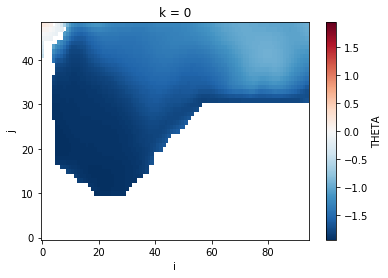

In [9]:
#testing to see if correctly sliced desired region
sst_mean = ds.THETA.sel(**lat_range, **lon_range).sel(k=0).mean(dim='time')
surface_mask = (coords.hFacC[0].isel(**lat_range, **lon_range)>0)
sst_mean.where(surface_mask).plot()

## <span style='color:Brown'> Bottom Potential Temperatures

In [10]:
#this gives us the depth of the bottom cell
depth_max = ds.k.where(coords.hFacC > 0).max(dim='k').load()

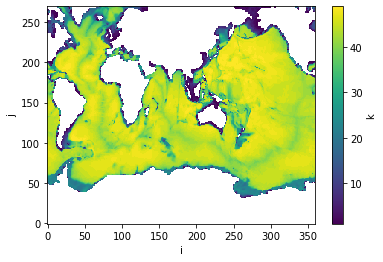

In [11]:
depth_max.plot()

In [12]:
bottom_temp = ds.THETA.mean(dim='time').isel(k=depth_max.fillna(0.).astype('i4'))
bottom_temp_wg = bottom_temp.isel(**lat_range, **lon_range)

In [13]:
bottom_temp_wg.load()

<xarray.DataArray 'THETA' (j: 49, i: 95)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.7710441 ,  1.761797  ,  1.3248782 , ..., -0.60652184,
        -0.60673106, -0.60680985],
       [ 0.5656107 ,  1.8291067 ,  1.680977  , ..., -0.60746765,
        -0.6074577 , -0.6074615 ],
       [ 0.13080381,  0.2509648 ,  1.8400244 , ..., -0.60863924,
        -0.6083164 , -0.608207  ]], dtype=float32)
Coordinates:
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 47 47 47 47 47 47 47 47 47
Dimensions without coordinates: j, i

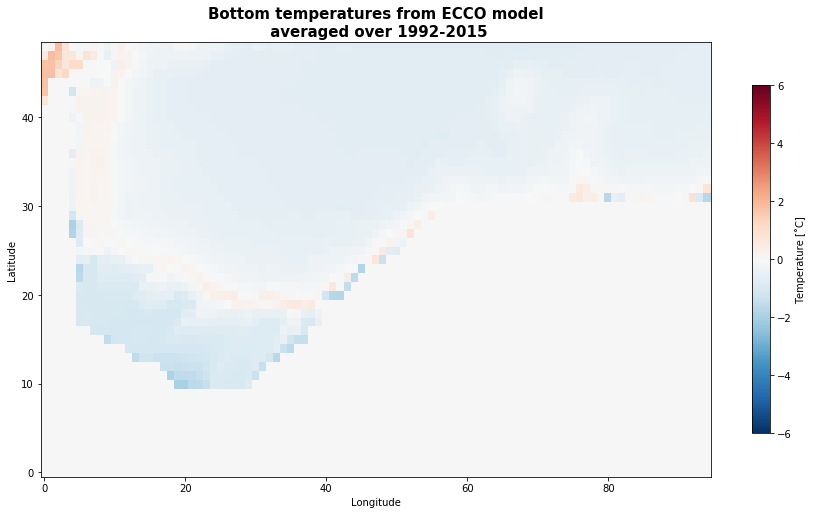

In [14]:
bottom_temp_wg.plot(figsize=(15,8), cbar_kwargs={'shrink':0.8, 'label':'Temperature [˚C]'}, cmap='RdBu_r', vmax=6)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Bottom temperatures from ECCO model\n averaged over 1992-2015', fontsize=15, weight='bold');

In [15]:
surface_mask = (coords.hFacC[0].isel(**lat_range, **lon_range)>0).load()

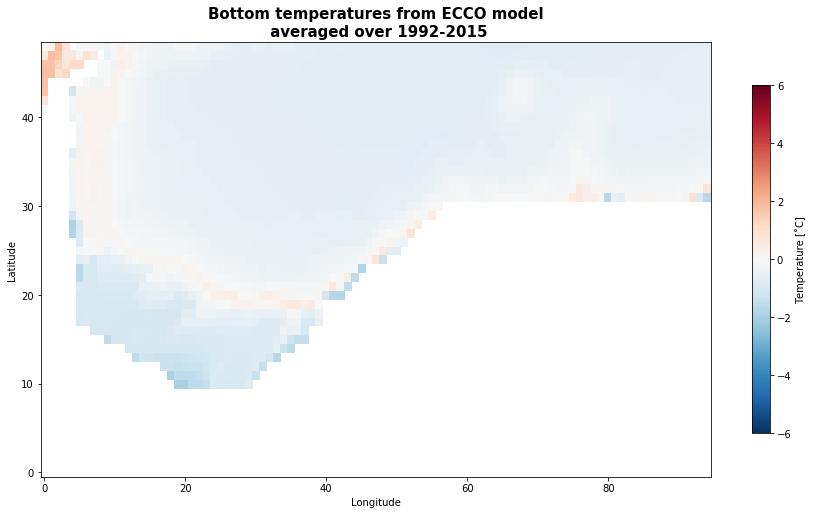

In [16]:
bottom_temp_wg.where(surface_mask).plot(figsize=(15,8), cbar_kwargs={'shrink':0.8, 'label':'Temperature [˚C]'}, cmap='RdBu_r', vmax=6)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Bottom temperatures from ECCO model\n averaged over 1992-2015', fontsize=15, weight='bold');

##  <span style='color:Magenta'> Plotting w Cartopy

In [61]:
bottom_temp_wg['j'] = coords_before_drop.j.isel(**lat_range)
bottom_temp_wg['i'] = coords_before_drop.i.isel(**lon_range)
bottom_temp_wg

<xarray.DataArray 'THETA' (j: 49, i: 95)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.7710441 ,  1.761797  ,  1.3248782 , ..., -0.60652184,
        -0.60673106, -0.60680985],
       [ 0.5656107 ,  1.8291067 ,  1.680977  , ..., -0.60746765,
        -0.6074577 , -0.6074615 ],
       [ 0.13080381,  0.2509648 ,  1.8400244 , ..., -0.60863924,
        -0.6083164 , -0.608207  ]], dtype=float32)
Coordinates:
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 47 47 47 47 47 47 47 47 47
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 70 71 72 73 74 75 76 77 78
  * i        (i) int64 333 334 335 336 337 338 339 340 ... 61 62 63 64 65 66 67
             (i) int64 333 334 335 336 337 338 339 340 ... 61 62 63 64 65 66 67

In [108]:
lon = coords_before_drop.XC.isel(**lon_range, **lat_range)
lat = coords_before_drop.YC.isel(**lat_range, **lon_range)

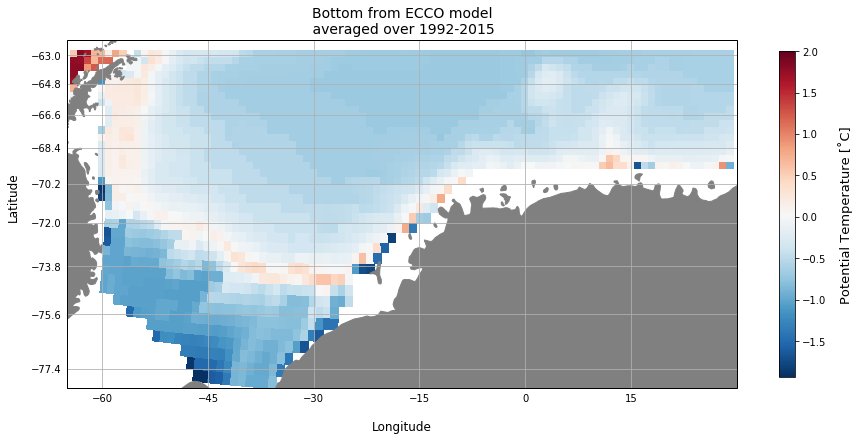

In [124]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(lon, lat, bottom_temp_wg.where(surface_mask), transform=ccrs.PlateCarree(), cmap='RdBu_r', vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature [˚C]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Bottom from ECCO model\n averaged over 1992-2015', fontsize=14);

## Bottom Salinity

In [125]:
bottom_slt = ds.SALT.mean(dim='time').isel(k=depth_max.fillna(0.).astype('i4'))

In [126]:
bottom_slt_wg = bottom_slt.isel(**lat_range, **lon_range)

In [127]:
bottom_slt_wg.load()

<xarray.DataArray 'SALT' (j: 49, i: 95)>
array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [34.67952 , 34.68407 , 34.558174, ..., 34.66905 , 34.6687  ,
        34.668346],
       [34.712524, 34.675987, 34.642563, ..., 34.669094, 34.668713,
        34.668335],
       [34.702316, 34.706017, 34.671707, ..., 34.66919 , 34.66878 ,
        34.66838 ]], dtype=float32)
Coordinates:
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 47 47 47 47 47 47 47 47 47
Dimensions without coordinates: j, i

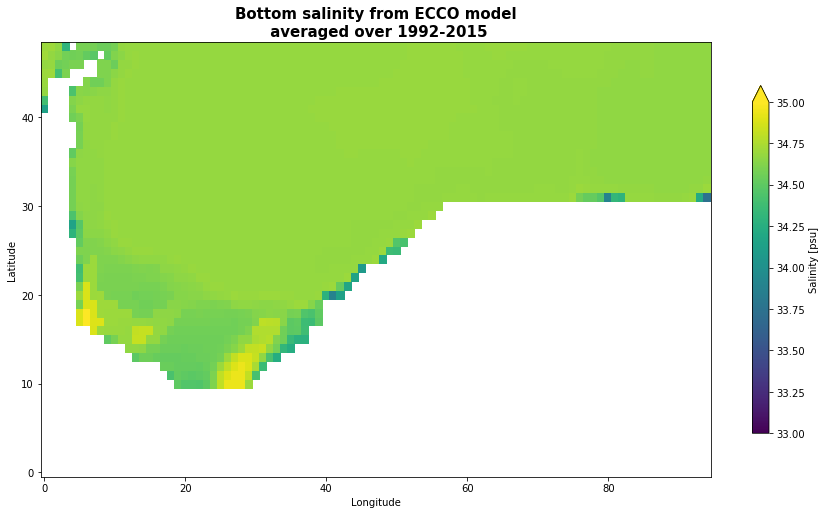

In [128]:
bottom_slt_wg.where(surface_mask).plot(figsize=(15,8), cbar_kwargs={'shrink':0.8, 'label':'Salinity [psu]'}, vmin=33, vmax=35)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Bottom salinity from ECCO model\n averaged over 1992-2015', fontsize=15, weight='bold');

##  <span style='color:Magenta'> Plotting w Cartopy

In [134]:
bottom_slt_wg['j'] = coords_before_drop.j.isel(**lat_range)
bottom_slt_wg['i'] = coords_before_drop.i.isel(**lon_range)
bottom_slt_wg

<xarray.DataArray 'SALT' (j: 49, i: 95)>
array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [34.67952 , 34.68407 , 34.558174, ..., 34.66905 , 34.6687  ,
        34.668346],
       [34.712524, 34.675987, 34.642563, ..., 34.669094, 34.668713,
        34.668335],
       [34.702316, 34.706017, 34.671707, ..., 34.66919 , 34.66878 ,
        34.66838 ]], dtype=float32)
Coordinates:
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 47 47 47 47 47 47 47 47 47
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 70 71 72 73 74 75 76 77 78
  * i        (i) int64 333 334 335 336 337 338 339 340 ... 61 62 63 64 65 66 67

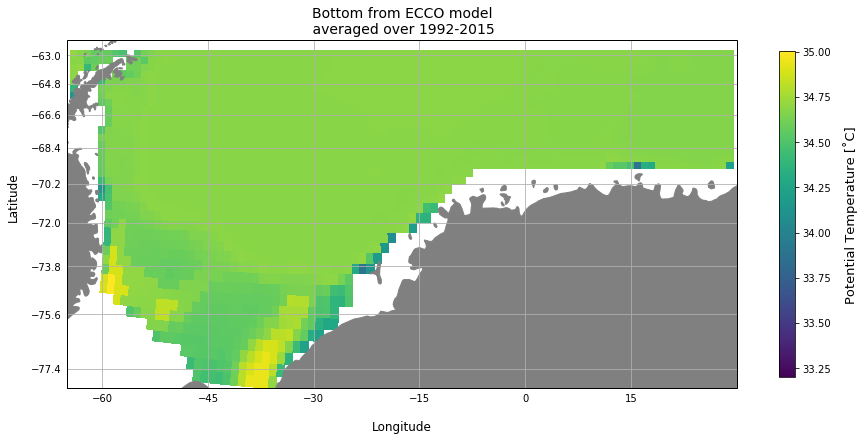

In [143]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))

im = ax.pcolormesh(lon, lat, bottom_slt_wg.where(surface_mask), transform=ccrs.PlateCarree(), cmap='viridis', vmin=33.2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature [˚C]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Bottom from ECCO model\n averaged over 1992-2015', fontsize=14);